In [18]:
using CSV, DataFrames, TimeSeries, DataStructures, Plots, PlutoUI,  Clustering
using GraphPlot, Graphs, Multigraphs, BSON, TextAnalysis, URIs, PyPlot
using IterTools: product
using StatsBase: maximum, minimum, median, mean
import Base, Statistics.mean
include("../influencecascade_platform.jl")
include("../entropy.jl")
include("../tool_helper.jl")
include("../visualizations.jl")

plot_actors_per_level (generic function with 1 method)

In [7]:
datafolder = "../../Data/Twitter/"
datafiles = [datafolder * file for file in readdir(datafolder) if occursin(".csv", file)]

1-element Vector{String}:
 "../../Data/Twitter/cop26_whole_period_extended_2.csv"

In [68]:
df = CSV.read(datafiles[1], DataFrame, header=1, types=String)

,id,author_id,username,created_at
,String,String,String,String
1,1459309016899887104,1120323655,ZenTaoPrincess,2021-11-12T23:55:56.000Z
2,1459306377814450181,77244409,deesbarbara,2021-11-12T23:45:27.000Z
3,1459302851902062593,1457421352135180288,GreenifyNow,2021-11-12T23:31:27.000Z
4,1459302367166447622,59119508,EricaDeGrace,2021-11-12T23:29:31.000Z
5,1459298061952462848,300379965,SW_London_GP,2021-11-12T23:12:25.000Z
6,1459297961016496134,300379965,SW_London_GP,2021-11-12T23:12:01.000Z
7,1459296426224242690,12552772,ajtrcbecg,2021-11-12T23:05:55.000Z
8,1459296223660326916,21392184,dan_grey,2021-11-12T23:05:06.000Z
9,1459290469310124041,879083139808800768,SovranitaLavoro,2021-11-12T22:42:14.000Z


In [70]:
show(df, allcols=true)

15785×13 DataFrame
   Row │ id                   author_id            username         created_at                lang    text                               original_text                      hashtags                           category       URLs                               country         country_code  sentiment 
       │ String               String               String           String                    String  String                             String                             String?                            String         String                             String?         String?       String    
───────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     1 │ 1459309016899887104  1120323655           ZenTaoPrincess   2021-11-12T23:55:56

In [72]:
a = missing

missing

In [97]:
a = "'∀a ∀ x ∃ y∀'"
first(a) == '\''
String(collect(a)[2:end-1])

"∀a ∀ x ∃ y∀"

In [98]:
function str_to_vec(string)
    if ismissing(string)
        return missing
    end
    list = split(string[2:end-1], "', ")
    res = []
    for str in list
        if first(str) == '\'' && last(str) == '\''
            push!(res, String(collect(str)[2:end-1]))
        elseif first(str) == '\''
            push!(res, String(collect(str)[2:end]))
        elseif last(str) == '\''
            push!(res, String(collect(str)[1:end-1]))
        end
    end
    return res
end

df."hashtags" = df."hashtags" .|> str_to_vec
df."category" = df."category" .|> str_to_vec
df."URLs" = df."URLs" .|> str_to_vec

15785-element Vector{Vector{Any}}:
 ["https://www.cnn.com/2021/11/11/tech/tidal-energy-climate-change-renewable/index.html?utm_term=link&utm_source=twCNNi&utm_medium=social&utm_content=2021-11-12T06%3A31%3A01"]
 ["https://www.cnn.com/2021/11/12/americas/birds-bodies-amazon-rainforest-climate-change-scn/index.html"]
 ["https://www.cnn.com/2021/11/12/americas/birds-bodies-amazon-rainforest-climate-change-scn/index.html"]
 ["https://edition.cnn.com/2021/11/09/world/cop26-climate-talks-race-intl/index.html"]
 ["https://www.greenpeace.org/international/story/50689/carbon-offsets-net-zero-greenwashing-scam/"]
 ["https://www.greenpeace.org/international/story/50689/carbon-offsets-net-zero-greenwashing-scam/?utm_medium=share&utm_content=postid-50689&utm_campaign=COP26&utm_source=twitter"]
 ["https://www.cnn.com/2021/10/12/opinions/climate-change-clean-energy-bader/index.html"]
 ["https://edition.cnn.com/2021/11/11/world/china-india-bolivia-cop26-climate-intl/index.html"]
 ["https://www.foxnews

In [100]:
show(df, allcols=true)
df."hashtags"[4]

15785×13 DataFrame
   Row │ id                   author_id            username         created_at                lang    text                               original_text                      hashtags                           category          URLs                               country         country_code  sentiment 
       │ String               String               String           String                    String  String                             String                             Array…?                            Array…            Array…                             String?         String?       String    
───────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     1 │ 1459309016899887104  1120323655           ZenTaoPrincess   2021-11-12

5-element Vector{Any}:
 "COP26"
 "reconciliation"
 "decolonization"
 "IndigenousKnowledge"
 "ClimateChange"

In [26]:
frames = [CSV.read(file, DataFrame; header=7) for file in datafiles]
data = vcat(frames...)
clean_dates = x -> floor(DateTime(split(x, '.')[1], "yyyy-mm-dd HH:MM:ss"), Dates.Minute(5));
data.time = clean_dates.(data.Date);
data = data[.~ismissing.(data."Expanded URLs"), :]

part_fun = sentiment
actor_fun = country
action_fun = trust_popularity_score

trust_popularity_score (generic function with 1 method)

In [28]:
cuttoff = 0.5
et = "Any Edge"
part = "neutral"

"neutral"

In [29]:
df = data |> part_fun |> action_fun |> actor_fun |> x->sort(x,:time)
	
tsg = TimeSeriesGenerator(:actor, :action, :partition)
time_series = observe(df, tsg)

ig = InfluenceGrapher(unique(df[!, tsg.action_col]))
influence_graph = observe(time_series, ig)


3-element Vector{Matrix{Matrix}}:
 [[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [2.1734384237242934 2.2928833138081335 0.0 0.0; 0.6630865757175509 0.0 0.0 0.0; 0.0 0.021977983729619868 0.0 0.0; 0.0 0.0 0.0 0.0] … [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]; [2.174303051006484 0.6631473635730564 0.004272578488924856 0.0; 2.291287752469141 0.8407241700038918 0.02152154843897414 0.0; 3.5207385841834595 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] … [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]; … ; [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] … [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0] [0.0 0.0 0.0 0.0; 0.0 0.0

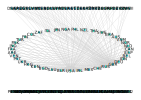

In [30]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end
	s = make_simplifier(et)

	icg = InfluenceCascadeGenerator(s)
	influence_cascades = observe.(influence_graph, Ref(icg));
	all_ics = vcat(influence_cascades...);
	
	i = (1:length(unique(df[!,tsg.part_col])))[findfirst(x->x==part, unique(df[!,tsg.part_col]))]
	xs, ys, influencers = influence_layout(influence_graph[i]; simplifier=s)
	g = print_graph(influence_graph[i]; simplifier=s)
	gplot(g, xs, ys, nodelabel=unique(df.actor))	
end

In [156]:
iso_codes = unique(df.actor)
indices = indexin(iso_codes, df.actor)
countries = df."Country"[indices]

for (i, e) in enumerate(edges(g))
    trace = scattergeo(  
	    	mode = "markers+lines",
	    	locations = [iso_codes[src(e)], iso_codes[dst(e)]],
	    	marker = attr(size = 8, color="blue"),
			line = attr(color="red", width=1),
			showlegend=false,
			name="",
			hovertext = [countries[src(e)], countries[dst(e)]],
			)
	if i == 1
		plots = [trace]
	else
    	push!(plots, trace)
	end
end

layout = Layout(
	#title_text = "Contour lines over globe<br>(Click and drag to rotate)",
    showlegend = false,
    geo = attr(
        showland = true,
        showcountries = true,
        showocean = true,
        countrywidth = 0.5,
        #landcolor = "rgb(230, 145, 56)",
        #lakecolor = "rgb(0, 255, 255)",
        #oceancolor = "rgb(0, 255, 255)",
		projection = attr(type = "natural earth"),
		#scope = "africa",
        lonaxis = attr(
        	showgrid = true,
        	gridcolor = "rgb(102, 102, 102)",
        	gridwidth = 0.5,
			#range = [0, 1]),
		),
		lataxis = attr(
			showgrid = true,
			gridcolor = "rgb(102, 102, 102)",
			gridwidth = 0.5)
	),
	modebar = attr(remove = ["zoomOutGeo"]),
	dragmode = "pan"
	)

	
PlotlyJS.plot(plots, layout)

data: [
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo with fields hovertext, line, locations, marker, mode, name, showlegend, and type",
  "scattergeo w

In [ ]:
plot_cascade(
	influence_cascades[1][9],
	unique(df[!, tsg.action_col]),
	length(unique(df[!, tsg.action_col])),
	cuttoff,
	range(colorant"blue", colorant"red", length(unique(df[!, tsg.action_col]))))

In [ ]:
plot_cascade_sankey(influence_cascades[1][9],
unique(df[!, tsg.action_col]),
cuttoff)

In [ ]:
actions = unique(df[!, tsg.action_col])

In [ ]:
b = repeat(actions, 2)

In [ ]:
nl = Vector{String}(undef, length(actions)*2)
for i in eachindex(actions)
    nl[i:length(actions):end] .= actions[i]
end

In [45]:
begin
    t1 = scattermapbox(
            mode = "markers+lines",
            lon = [france."Longitude (average)"[1], italie."Longitude (average)"[1]],
            lat = [france."Latitude (average)"[1], italie."Latitude (average)"[1]],
            marker = attr(size = 10),
            showlegend=false)

    t2 = scattermapbox(
        mode = "markers+lines",
        lon = [-50, -60, 40],
        lat = [30, 10, -20],
        marker = attr(size = 10),
        showlegend=false)
        
    layout = Layout(
            margin = attr(
                l = 0, 
                t = 0,
                b = 0,
                r = 0),
            mapbox = attr(
                #center = attr(lon = 10, lat = 10),
                style = "stamen-terrain",
                center = attr(lon = -20, lat = -20),
                zoom = 1),
            )
    
    
        PlotlyJS.plot([t1, t2], layout)
    end

data: [
  "scattermapbox with fields lat, lon, marker, mode, showlegend, and type",
  "scattermapbox with fields lat, lon, marker, mode, showlegend, and type"
]

layout: "layout with fields mapbox, margin, and template"